<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/ <br>
<b> You can cite this work with</b>:

@software{edwin_rueda_2020_3843381,<br>
  author       = {Edwin Rueda},<br>
  title        = {ejrueda/MasterUFPA: zenodo release},<br>
  month        = may,<br>
  year         = 2020,<br>
  publisher    = {Zenodo},<br>
  version      = {zenodo},<br>
  doi          = {10.5281/zenodo.3843381},<br>
  url          = {https://doi.org/10.5281/zenodo.3843381}<br>
}

- Para comparar los dos diferentes métodos y ver si sus resultados son estadisticamente diferentes, vamos a entrenar el clasificador a una clase propuesto con cada uno de los conjuntos aumentados mediante el algoritmo SMOTE y mediante la arquitectura GAN. Recordando que el algoritmo de clasificación tambien tiene unos parámetros por ajustar, así como el parámetro de cuanto porcentaje de datos aumentar.

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from utilities import EdwinRueda_utils
import pickle as pk
%matplotlib inline
print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)

tensorflow version:  2.3.3
numpy version:  1.18.5
matplotlib version:  3.3.4
sklearn version:  0.24.1


#### Conjunto de datos inicial

In [3]:
data = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
data.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


#### Genes de referencia

In [4]:
rg = open("./data/reference_genes.txt").read().splitlines()
print(rg)

['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [5]:
rg_data = data.reindex(rg).dropna()
rg_data

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


#### se escalan los datos

In [6]:
scaler = EdwinRueda_utils.scaler(xmin=-1, xmax=1)
scaler.fit(rg_data)
rg_data = scaler.transform(rg_data)
print("Reference genes scaled: ")
rg_data

Reference genes scaled: 


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


####  One-class SVM con los datos sin aumentar

In [7]:
num_folds = 4
num_iter = 15
obj = EdwinRueda_utils.ocsvm_utilities(np.asanyarray(rg_data), np.ones(rg_data.shape[0]), k_folds=num_folds)
nu_params = 30
params = {"nu":np.linspace(.001,0.5, nu_params)}
train_score, test_score = obj.get_best_params(params, n_iter=num_iter)

In [8]:
train_score.head()

,best_nu,score_cv_0,score_cv_1,score_cv_2,score_cv_3,score_cv_4,score_cv_5,score_cv_6,score_cv_7,score_cv_8,...,score_cv_50,score_cv_51,score_cv_52,score_cv_53,score_cv_54,score_cv_55,score_cv_56,score_cv_57,score_cv_58,score_cv_59
0.001000,1.0,0.600000,0.666667,0.466667,0.466667,0.400000,0.533333,0.600000,0.666667,0.666667,...,0.400000,0.533333,0.600000,0.533333,0.466667,0.600000,0.666667,0.333333,0.533333,0.533333
0.018207,13.0,0.666667,0.733333,0.666667,0.800000,0.733333,0.666667,0.866667,0.800000,0.666667,...,0.733333,0.666667,0.733333,0.666667,0.800000,0.733333,0.800000,0.733333,0.600000,0.733333
0.035414,0.0,0.733333,0.733333,0.666667,0.733333,0.666667,0.666667,0.800000,0.800000,0.666667,...,0.666667,0.800000,0.800000,0.800000,0.866667,0.733333,0.800000,0.733333,0.666667,0.733333
0.052621,0.0,0.800000,0.733333,0.800000,0.733333,0.733333,0.733333,0.733333,0.800000,0.733333,...,0.666667,0.800000,0.800000,0.800000,0.666667,0.733333,0.800000,0.733333,0.666667,0.733333
0.069828,0.0,0.733333,0.733333,0.800000,0.800000,0.733333,0.666667,0.666667,0.733333,0.733333,...,0.933333,0.800000,0.800000,0.666667,0.666667,0.800000,0.800000,0.666667,0.600000,0.666667


#### valores nu que fueron escogidos como mejores
- si hay dos mejores parámetros se escoje el que presente menor desviación estandar en su score

In [9]:
best_nu = test_score.where(train_score.best_nu>=1).dropna()
best_nu

,best_nu,score_cv_0,score_cv_1,score_cv_2,score_cv_3,score_cv_4,score_cv_5,score_cv_6,score_cv_7,score_cv_8,...,score_cv_50,score_cv_51,score_cv_52,score_cv_53,score_cv_54,score_cv_55,score_cv_56,score_cv_57,score_cv_58,score_cv_59
0.001000,1.0,0.4,0.6,0.4,0.8,0.6,0.2,0.6,0.4,0.6,...,0.6,0.6,0.6,0.6,0.4,0.0,0.0,1.0,0.2,0.2
0.018207,13.0,0.4,0.8,0.4,0.8,0.8,0.2,0.6,0.6,0.6,...,0.6,0.6,0.4,0.8,0.6,0.0,0.0,1.0,0.6,0.6
0.362345,1.0,0.2,0.8,0.4,0.8,0.8,0.2,0.6,0.4,0.6,...,0.2,0.6,0.4,0.6,0.6,0.0,0.0,0.8,0.6,0.6


In [10]:
best_nu_param = best_nu.where(best_nu.best_nu==best_nu.best_nu.max()).dropna().index[0]
best_nu_param

0.01820689655172414

Text(0.33, 0.14, 'best nu: 0.01820689655172414')

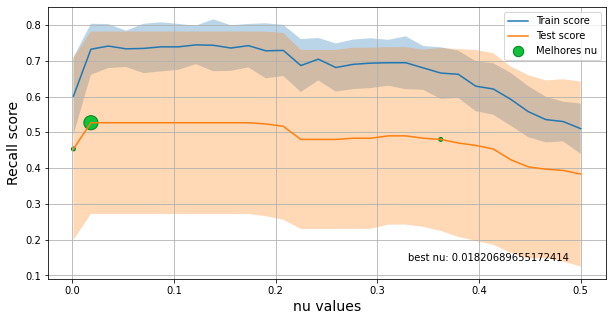

In [11]:
plt.figure(figsize=(10,5))
train_mean = train_score.iloc[:,1:].mean(axis=1).values
train_std = train_score.iloc[:,1:].std(axis=1)
plt.plot(train_score.index, train_mean, label="Train score");
plt.fill_between(train_score.index, train_mean-train_std,
                train_mean+train_std, alpha=.3)

test_mean = test_score.iloc[:,1:].mean(axis=1).values
test_std = test_score.iloc[:,1:].std(axis=1)
plt.plot(test_score.index, test_mean, label="Test score");
plt.fill_between(test_score.index, test_mean-test_std,
                test_mean+test_std, alpha=.3)

s = best_nu["best_nu"].values/best_nu["best_nu"].values.max()*200
plt.scatter(best_nu.index, best_nu.iloc[:,1:].mean(axis=1), s=s, label="Melhores nu", color="#0FC238",
            edgecolors="#00801D")

plt.legend()
plt.ylabel("Recall score", fontsize=14)
plt.xlabel("nu values", fontsize=14)
plt.grid();
plt.annotate("best nu: " + str(best_nu_param), (.33, .14))
plt.savefig("./results/recall_score_in_unaugmented_data.svg")

#### Entrenamos el clasificador con el mejor parámetro nu encontrado

In [12]:
train_recall_score, test_recall_score = obj.get_statistics(iterations=50)

In [13]:
np.round(np.mean(train_recall_score),4), np.mean(test_recall_score)

(0.7271, 0.48999999999999994)

In [14]:
bu = EdwinRueda_utils.bokeh_utils()
[lo_train, q25_train, q50_train, q75_train, up_train], otrain = bu.boxtplot_values(np.array(train_recall_score),
                                                                                  min_value=True, max_value=True)
[lo_test, q25_test, q50_test, q75_test, up_test], otest = bu.boxtplot_values(np.array(test_recall_score),
                                                                            min_value=True, max_value=True)

In [15]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, export_svgs
from bokeh.transform import jitter
from bokeh.models import ColumnDataSource
output_notebook()

Loading BokehJS ...

In [16]:
x_ticks = ["Train", "Test"]
p = figure(x_range=x_ticks, width=300, height=250, background_fill_color="#efefef")
#lower and upper rects
p.rect(x_ticks, [lo_train, lo_test], width=.12, height=.0005, line_color="black")
p.rect(x_ticks, [up_train, up_test], width=.12, height=.0005, line_color="black")
#segments
p.segment(x_ticks, [lo_train, lo_test], x_ticks, [q25_train, q25_test], line_color="black")
p.segment(x_ticks, [q75_train, q75_test], x_ticks, [up_train, up_test], line_color="black")
#vars
p.vbar(x_ticks, 0.35, [q50_train, q50_test], [q25_train, q25_test], line_color="black", fill_color="#E08E79")
p.vbar(x_ticks, 0.35, [q50_train, q50_test], [q75_train, q75_test], line_color="black", fill_color="#3B8686")
p.xaxis.axis_label = "conjunto de dados"
p.yaxis.axis_label = "pontuação recall"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"

#outliers
if len(otrain!=0):
    p.circle([x_ticks[0]]*len(otrain), otrain, color="orange", line_width=3)
if len(otest!=0):
    p.circle([x_ticks[1]]*len(otest), otest, color="orange", line_width=3)

show(p)
p.output_backend = "svg"
export_svgs(p, filename="./results/recall_score_boxplot_in_unaugmented_data.svg")

### Resultados aumentando el conjunto de entrenamiento con el algoritmo SMOTE

In [17]:
smote = EdwinRueda_utils.SMOTE()

In [18]:
percentages = np.arange(25, 1000, 25)
percentages

array([ 25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325,
       350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650,
       675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975])

#### mejores parámetros obtenidos en el notebook "selectiong the best smote algorithm (tuning parameters)"

In [19]:
k = 5
s = 0.1473684210526316

num_folds = 4
num_iter = 15
smote_train_mean_score_p = []
smote_train_std_score_p = []
smote_test_mean_score_p = []
smote_test_std_score_p = []
for p in percentages:
    tic = time()
    synthetic_genes = smote.smote(np.array(rg_data), p, k=k, s=s)
    augmented_data = np.concatenate((rg_data, synthetic_genes), axis=0)
    obj = EdwinRueda_utils.ocsvm_utilities(augmented_data, np.ones(augmented_data.shape[0]),k_folds=num_folds)
    nu_params = 30
    params = {"nu":np.linspace(.001,0.5, nu_params)}
    train_score, test_score = obj.get_best_params(params, n_iter=num_iter)
    train_recall_score, test_recall_score = obj.get_statistics(iterations=30, test_size=.3)
    #train params
    smote_train_mean_score_p.append(np.mean(np.array(train_recall_score)))
    smote_train_std_score_p.append(np.std(np.array(train_recall_score)))
    #test params
    smote_test_mean_score_p.append(np.mean(np.array(test_recall_score)))
    smote_test_std_score_p.append(np.std(np.array(test_recall_score)))
    toc = time()
    print("{}% | data_shape: {} | : time: {} [s]".format(p, augmented_data.shape, toc-tic))
    #break

25% | data_shape: (25, 9) | : time: 5.837290525436401 [s]
50% | data_shape: (30, 9) | : time: 5.264785051345825 [s]
75% | data_shape: (35, 9) | : time: 5.3972227573394775 [s]
100% | data_shape: (40, 9) | : time: 5.340009689331055 [s]
125% | data_shape: (40, 9) | : time: 5.319052219390869 [s]
150% | data_shape: (40, 9) | : time: 5.301974534988403 [s]
175% | data_shape: (40, 9) | : time: 5.305095911026001 [s]
200% | data_shape: (60, 9) | : time: 5.459964990615845 [s]
225% | data_shape: (60, 9) | : time: 5.390897989273071 [s]
250% | data_shape: (60, 9) | : time: 5.365015745162964 [s]
275% | data_shape: (60, 9) | : time: 5.386461496353149 [s]
300% | data_shape: (80, 9) | : time: 5.513159513473511 [s]
325% | data_shape: (80, 9) | : time: 5.545888423919678 [s]
350% | data_shape: (80, 9) | : time: 5.510411977767944 [s]
375% | data_shape: (80, 9) | : time: 5.926688194274902 [s]
400% | data_shape: (100, 9) | : time: 5.710539817810059 [s]
425% | data_shape: (100, 9) | : time: 5.665205717086792 [

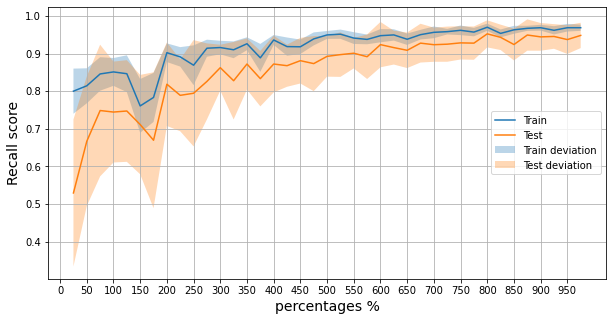

In [20]:
plt.figure(figsize=(10,5))
plt.plot(percentages, smote_train_mean_score_p, label="Train");
plt.fill_between(percentages, np.array(smote_train_mean_score_p)-np.array(smote_train_std_score_p),
                np.array(smote_train_mean_score_p)+np.array(smote_train_std_score_p), alpha=.3,
                label="Train deviation")
#test results
plt.plot(percentages, smote_test_mean_score_p, label="Test")
plt.fill_between(percentages, np.array(smote_test_mean_score_p)-np.array(smote_test_std_score_p),
                np.array(smote_test_mean_score_p)+np.array(smote_test_std_score_p), alpha=.3,
                 label="Test deviation")
plt.grid()
plt.ylabel("Recall score", fontsize=14)
plt.xlabel("percentages %", fontsize=14)
plt.xticks(range(0,1000, 50), range(0,1000, 50))
plt.legend(loc="center right");
plt.savefig("./results/recall_score_in_augmented_data_smote_best_params.svg")

In [21]:
smote_train_recall_score, smote_test_recall_score = obj.get_statistics(iterations=50, test_size=.3)

In [ ]:
pk.dump(smote_train_recall_score, open("./results/smote_train_recall_score.pk", "wb"))
pk.dump(smote_test_recall_score, open("./results/smote_test_recall_score.pk", "wb"))

In [6]:
smote_train_recall_score = pk.load(open("./results/smote_train_recall_score.pk", "rb"))
smote_test_recall_score = pk.load(open("./results/smote_test_recall_score.pk", "rb"))

In [22]:
bu = EdwinRueda_utils.bokeh_utils()
[s_l_train, s_q25_train, s_q50_train, s_q75_train, s_u_train], s_otrain = bu.boxtplot_values(np.array(smote_train_recall_score),
                                                                                  min_value=True, max_value=True)
[s_l_test, s_q25_test, s_q50_test, s_q75_test, s_u_test], s_otest = bu.boxtplot_values(np.array(smote_test_recall_score),
                                                                            min_value=True, max_value=True)

In [23]:
x_ticks = ["Treino", "Teste"]
p = figure(x_range=x_ticks, width=300, height=250, background_fill_color="#efefef")
#lower and upper rects
p.rect(x_ticks, [s_l_train, s_l_test], width=.12, height=.0008, line_color="black")
p.rect(x_ticks, [s_u_train, s_u_test], width=.12, height=.0008, line_color="black")
#segments
p.segment(x_ticks, [s_l_train, s_l_test], x_ticks, [s_q25_train, s_q25_test], line_color="black")
p.segment(x_ticks, [s_q75_train, s_q75_test], x_ticks, [s_u_train, s_u_test], line_color="black")
#vars
p.vbar(x_ticks, 0.35, [s_q50_train, s_q50_test], [s_q25_train, s_q25_test], line_color="black",
       fill_color="#E08E79")
p.vbar(x_ticks, 0.35, [s_q50_train, s_q50_test], [s_q75_train, s_q75_test], line_color="black",
       fill_color="#3B8686")
p.xaxis.axis_label = "conjunto de dados"
p.yaxis.axis_label = "pontuação recall"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"

#outliers
if len(s_otrain!=0):
    p.circle([x_ticks[0]]*len(s_otrain), s_otrain, color="orange", line_width=3)
if len(otest!=0):
    p.circle([x_ticks[1]]*len(s_otest), s_otest, color="orange", line_width=3)

show(p)
p.output_backend = "svg"
export_svgs(p, filename="./results/recall_score_boxplot_in_augmented_data_smote_best_params.svg")

#### Mejor arquitectura GAN - basados en el notebook "Selecting the best GAN architeture (tuning parameters)"

In [24]:
noise_shape = 50
num_syn_samples = 3

#Generator network
G1 = Sequential()
G1.add(Dense(50, input_shape=(noise_shape,)))
G1.add(Dense(150))
G1.add(Dropout(.15))
G1.add(Dense(9, activation="tanh"))

#synthetic sample
noise_input = tf.random_normal_initializer()((num_syn_samples, noise_shape))
print("noise input shape:", noise_input.shape)
print("---------------------------")
print("synthetic samples:")
synthetic_samples = G1(noise_input)
synthetic_samples

noise input shape: (3, 50)
---------------------------
synthetic samples:


<tf.Tensor: shape=(3, 9), dtype=float64, numpy=
array([[-0.08927691,  0.12088256, -0.01785731,  0.08772257, -0.08229681,
         0.03489416,  0.02714351,  0.04595655, -0.04204598],
       [ 0.0503759 , -0.09318263,  0.0317044 , -0.05423899,  0.03629275,
        -0.03300957, -0.04216338,  0.01447354,  0.00400053],
       [ 0.01120228,  0.04159806,  0.01080099,  0.00836594,  0.04485068,
        -0.04282491, -0.00561822, -0.04239669,  0.01143478]])>

In [25]:
#Discriminator network
D1 = Sequential()
D1.add(Dense(32, input_shape=(rg_data.shape[1],)))
D1.add(tf.keras.layers.LeakyReLU(alpha=.2))
D1.add(Dense(32))
D1.add(Dense(1, activation="sigmoid"))
print("output of the disriminator network:")
D1(synthetic_samples)

output of the disriminator network:


<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[0.51889203],
       [0.50253081],
       [0.50548196]])>

In [27]:
num_iterations = 20
epochs = 1700
precision1, kld1, loss_g1, loss_d1, s_metric_1 = [], [], [], [], []
train_times = []
for i in range(num_iterations):
    tic = time()
    init = tf.keras.initializers.glorot_uniform()
    init_weights = []
    for w in D1.get_weights():
        init_weights.append(init(w.shape))
    D1.set_weights(init_weights)
    
    init = tf.keras.initializers.glorot_uniform()
    init_weights = []
    for w in G1.get_weights():
        init_weights.append(init(w.shape))
    G1.set_weights(init_weights)    
    
    gan_utils1 = EdwinRueda_utils.gan_utils()
    optimizerG1 = tf.optimizers.SGD(learning_rate=0.00015, momentum=.92, decay=0.00015/epochs)
    optimizerD1 = tf.optimizers.SGD(learning_rate=0.001, momentum=.9, decay=0.001/epochs)
    accumulated_gloss, accumulated_dloss = gan_utils1.train(rg_data, G1, D1, noise_input=noise_shape,
                                                       epochs=epochs, batch_size=rg_data.shape[0],
                                                       optimizerG=optimizerG1, optimizerD=optimizerD1,
                                                       verbose=False)
    precision, kld, loss_g, loss_d, s_metric =  gan_utils1.get_metrics(num_iter=50)
    precision1.append(np.mean(precision))
    kld1.append(np.mean(kld))
    loss_g1.append(np.mean(loss_g))
    loss_d1.append(np.mean(loss_d))
    s_metric_1.append(np.mean(s_metric))
    toc = time()
    train_times.append(toc-tic)
    print("iteration: {}, time: {} [s]".format(i, toc-tic))

iteration: 0, time: 16.196992874145508 [s]
iteration: 1, time: 15.230493307113647 [s]
iteration: 2, time: 14.831011533737183 [s]
iteration: 3, time: 13.681745290756226 [s]
iteration: 4, time: 13.64015793800354 [s]
iteration: 5, time: 13.862656831741333 [s]
iteration: 6, time: 13.713690280914307 [s]
iteration: 7, time: 14.012333631515503 [s]
iteration: 8, time: 13.676225185394287 [s]
iteration: 9, time: 13.703195095062256 [s]
iteration: 10, time: 13.78275752067566 [s]
iteration: 11, time: 13.71983528137207 [s]
iteration: 12, time: 13.653974533081055 [s]
iteration: 13, time: 13.689459562301636 [s]
iteration: 14, time: 13.709167003631592 [s]
iteration: 15, time: 13.996882915496826 [s]
iteration: 16, time: 13.737091541290283 [s]
iteration: 17, time: 13.73456072807312 [s]
iteration: 18, time: 13.72614049911499 [s]
iteration: 19, time: 13.684518575668335 [s]


In [28]:
bokeh_utils = EdwinRueda_utils.bokeh_utils()

[pl_1, pq1_1, pq2_1, pq3_1, pu_1], pouts_1 = bokeh_utils.boxtplot_values(np.array(precision1), True, True)
[kl_1, kq1_1, kq2_1, kq3_1, ku_1], kouts_1 = bokeh_utils.boxtplot_values(np.array(kld1), True, True)
[gl_1, gq1_1, gq2_1, gq3_1, gu_1], gouts_1 = bokeh_utils.boxtplot_values(np.array(loss_g1), True, True)
[dl_1, dq1_1, dq2_1, dq3_1, du_1], douts_1 = bokeh_utils.boxtplot_values(np.array(loss_d1), True, True)
[sl_1, sq1_1, sq2_1, sq3_1, su_1], souts_1 = bokeh_utils.boxtplot_values(np.array(s_metric), True, True)

In [29]:
cats = ["precision","s_metric", "KLD", "loss_G", "loss_D"]
p = figure(plot_height=200, plot_width=350, x_range=cats, background_fill_color="#E8E8E8",)
p.rect(cats, [pl_1, sl_1, kl_1, gl_1, dl_1], width=.2, height=.001, line_color="black")
p.segment(cats, [pl_1, sl_1, kl_1, gl_1, dl_1], cats, [pq1_1, sq1_1, kq1_1, gq1_1, dq1_1], line_color="black")
p.vbar(cats, width=.4, top=[pq2_1, sq2_1, kq2_1, gq2_1, dq2_1], bottom=[pq1_1, sq1_1, kq1_1, gq1_1, dq1_1],
       fill_color="#3B8686", line_color="black")
p.vbar(cats, width=.4, top=[pq3_1, sq3_1, kq3_1, gq3_1, dq3_1], bottom=[pq2_1, sq2_1, kq2_1, gq2_1, dq2_1],
       fill_color="#E08E79", line_color="black")
p.segment(cats, [pq3_1, sq3_1, kq3_1, gq3_1, dq3_1], cats, [pu_1, su_1, ku_1, gu_1, du_1], line_color="black")
p.rect(cats, [pu_1, su_1, ku_1, gu_1, du_1], width=.2, height=.001, line_color="black")
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 1
p.yaxis.ticker = np.arange(0,1.1,.1)

#outliers
list_outs = [pouts_1, souts_1, kouts_1, gouts_1, douts_1]
for idx in range(len(cats)):
    aux_var = list_outs[idx]
    if len(aux_var)>0:
        p.circle([cats[idx] for i in range(len(aux_var))], aux_var, line_color="#FF8000",
                fill_color="#FFA851", size=4)
    
show(p)

In [30]:
percentages = np.arange(25, 1000, 25)
num_folds = 4
num_iter = 15
gan_train_mean_score_p = []
gan_train_std_score_p = []
gan_test_mean_score_p = []
gan_test_std_score_p = []
for p in percentages:
    tic = time()
    noise_vector = tf.random.normal(shape=(int((rg_data.shape[0]*p)/100), noise_shape))
    synthetic_genes = gan_utils1.G(noise_vector).numpy()
    augmented_data = np.concatenate((rg_data, synthetic_genes), axis=0)
    obj = EdwinRueda_utils.ocsvm_utilities(augmented_data, np.ones(augmented_data.shape[0]),k_folds=num_folds)
    nu_params = 30
    params = {"nu":np.linspace(.001,0.5, nu_params)}
    train_score, test_score = obj.get_best_params(params, n_iter=num_iter)
    train_recall_score, test_recall_score = obj.get_statistics(iterations=30, test_size=.3)
    #train params
    gan_train_mean_score_p.append(np.mean(np.array(train_recall_score)))
    gan_train_std_score_p.append(np.std(np.array(train_recall_score)))
    #test params
    gan_test_mean_score_p.append(np.mean(np.array(test_recall_score)))
    gan_test_std_score_p.append(np.std(np.array(test_recall_score)))
    toc = time()
    print("{}% | data_shape: {} | : time: {} [s]".format(p, augmented_data.shape, toc-tic))

25% | data_shape: (25, 9) | : time: 8.322986602783203 [s]
50% | data_shape: (30, 9) | : time: 5.288560390472412 [s]
75% | data_shape: (35, 9) | : time: 5.143161296844482 [s]
100% | data_shape: (40, 9) | : time: 5.20331883430481 [s]
125% | data_shape: (45, 9) | : time: 5.300137042999268 [s]
150% | data_shape: (50, 9) | : time: 5.257005929946899 [s]
175% | data_shape: (55, 9) | : time: 5.429922103881836 [s]
200% | data_shape: (60, 9) | : time: 5.48603630065918 [s]
225% | data_shape: (65, 9) | : time: 5.3049092292785645 [s]
250% | data_shape: (70, 9) | : time: 5.577582836151123 [s]
275% | data_shape: (75, 9) | : time: 5.3614821434021 [s]
300% | data_shape: (80, 9) | : time: 5.393024206161499 [s]
325% | data_shape: (85, 9) | : time: 5.435884952545166 [s]
350% | data_shape: (90, 9) | : time: 5.460941791534424 [s]
375% | data_shape: (95, 9) | : time: 5.509539842605591 [s]
400% | data_shape: (100, 9) | : time: 5.6242899894714355 [s]
425% | data_shape: (105, 9) | : time: 5.571068286895752 [s]


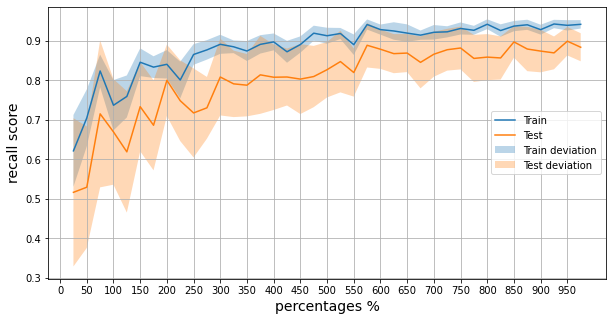

In [31]:
plt.figure(figsize=(10,5))
plt.plot(percentages, gan_train_mean_score_p, label="Train");
plt.fill_between(percentages, np.array(gan_train_mean_score_p)-np.array(gan_train_std_score_p),
                np.array(gan_train_mean_score_p)+np.array(gan_train_std_score_p), alpha=.3,
                label="Train deviation")
#test results
plt.plot(percentages, gan_test_mean_score_p, label="Test")
plt.fill_between(percentages, np.array(gan_test_mean_score_p)-np.array(gan_test_std_score_p),
                np.array(gan_test_mean_score_p)+np.array(gan_test_std_score_p), alpha=.3,
                label="Test deviation")
plt.grid()
plt.ylabel("recall score", fontsize=14)
plt.xlabel("percentages %", fontsize=14)
plt.xticks(range(0,1000, 50), range(0,1000, 50))
plt.legend(loc="center right");
plt.savefig("./results/recall_score_in_augmented_data_gan_best_params.svg")

In [45]:
gan_train_recall_score, gan_test_recall_score = obj.get_statistics(iterations=50)

In [59]:
pk.dump(gan_train_recall_score, open("./results/gan_train_recall_score.pk", "wb"))
pk.dump(gan_test_recall_score, open("./results/gan_test_recall_score.pk", "wb"))

In [32]:
gan_train_recall_score = pk.load(open("./results/gan_train_recall_score.pk", "rb"))
gan_test_recall_score = pk.load(open("./results/gan_test_recall_score.pk", "rb"))

In [33]:
bu = EdwinRueda_utils.bokeh_utils()
[gan_l_train, gan_q25_train, gan_q50_train, gan_q75_train, gan_u_train], gan_otrain = bu.boxtplot_values(np.array(gan_train_recall_score),
                                                                                                         min_value=True, max_value=True)
[gan_l_test, gan_q25_test, gan_q50_test, gan_q75_test, gan_u_test], gan_otest = bu.boxtplot_values(np.array(gan_test_recall_score),
                                                                                                   min_value=True, max_value=True)

In [34]:
x_ticks = ["Treino", "Teste"]
p = figure(x_range=x_ticks, width=300, height=250, background_fill_color="#efefef")
#lower and upper rects
p.rect(x_ticks, [gan_l_train, gan_l_test], width=.12, height=.0005, line_color="black")
p.rect(x_ticks, [gan_u_train, gan_u_test], width=.12, height=.0005, line_color="black")
#segments
p.segment(x_ticks, [gan_l_train, gan_l_test], x_ticks, [gan_q25_train, gan_q25_test], line_color="black")
p.segment(x_ticks, [gan_q75_train, gan_q75_test], x_ticks, [gan_u_train, gan_u_test], line_color="black")
#vars
p.vbar(x_ticks, 0.35, [gan_q50_train, gan_q50_test], [gan_q25_train, gan_q25_test], line_color="black", fill_color="#E08E79")
p.vbar(x_ticks, 0.35, [gan_q50_train, gan_q50_test], [gan_q75_train, gan_q75_test], line_color="black", fill_color="#3B8686")
p.xaxis.axis_label = "conjunto de dados"
p.yaxis.axis_label = "pontuação recall"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"

#outliers
if len(otrain!=0):
    p.circle([x_ticks[0]]*len(gan_otrain), gan_otrain, color="orange", line_width=3)
if len(otest!=0):
    p.circle([x_ticks[1]]*len(gan_otest), gan_otest, color="orange", line_width=3)

show(p)
p.output_backend = "svg"
export_svgs(p, filename="./results/recall_score_boxplot_in_augmented_data_gan_best_params.svg")

['./results/recall_score_boxplot_in_augmented_data_gan_best_params.svg']

### Comparando los resultados de los diferentes métodos

#### comparando los genes sintéticos generados
- Definimos un porcentaje de aumento del 700% para comparar los métodos 

(180, 9) (180, 9)


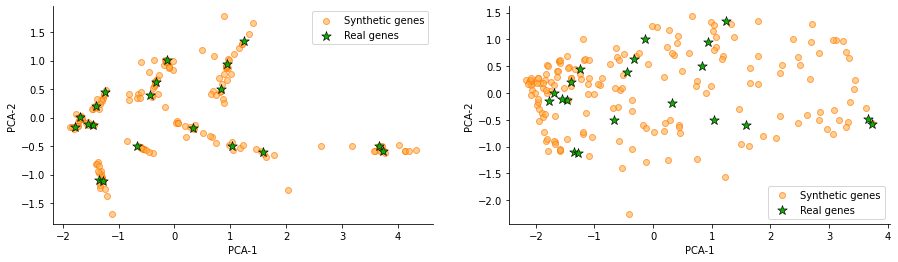

In [35]:
k = 4
s = 0.24210526315789474
percentage = 900
smote_syn_samples = smote.smote(np.array(rg_data), N=percentage, k=k, s=s)
noise_vector = tf.random.normal(shape=(int((rg_data.shape[0]*percentage)/100), noise_shape))
gan_syn_samples = gan_utils1.G(noise_vector).numpy()
print(smote_syn_samples.shape, gan_syn_samples.shape)
pca = PCA(n_components=2)
rg_data_pca = pca.fit_transform(rg_data)
smote_syn_samples_pca = pca.transform(smote_syn_samples)
gan_syn_samples_pca = pca.transform(gan_syn_samples)

plt.figure(figsize=(15,4))
ax1 = plt.subplot(1,2,1)
plt.scatter(smote_syn_samples_pca[:,0], smote_syn_samples_pca[:,1], color="#FFB147", alpha=.6,
           edgecolors="#FF7400", label="Synthetic genes")
plt.scatter(rg_data_pca[:,0], rg_data_pca[:,1], color="#10AC03", marker="*", s=100, edgecolors="black",
           linewidths=.6, label="Real genes");
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.xlabel("PCA-1");
plt.ylabel("PCA-2");
#plt.title("Dados aumentados com o algoritmo SMOTE")
plt.legend();

ax2 = plt.subplot(1,2,2)
plt.scatter(gan_syn_samples_pca[:,0], gan_syn_samples_pca[:,1], color="#FFB147", alpha=.6,
           edgecolors="#FF7400", label="Synthetic genes")
plt.scatter(rg_data_pca[:,0], rg_data_pca[:,1], color="#10AC03", marker="*", s=100, edgecolors="black",
           linewidths=.6, label="Real genes");
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.xlabel("PCA-1");
plt.ylabel("PCA-2");
#plt.title("Dados aumentados com a arquitetura GAN")
plt.legend();

plt.savefig("./results/reference_genes_augmented_smote_gan.svg")

#### Conclusiones
- Como se puede observar el algoritmo SMOTE no genera nuevos ejemplos, solo altera los ya existentes, es por eso que el espacio en el que se ubican los genes sintéticos es bien cercano al espacio donde se encuentran los reales
- La arquitectura GAN consigue generar nuevos genes sintéticos ya que esta intenta capturar la distribución de los genes reales.

#### comparando el recall score a medida que se aumenta los datos

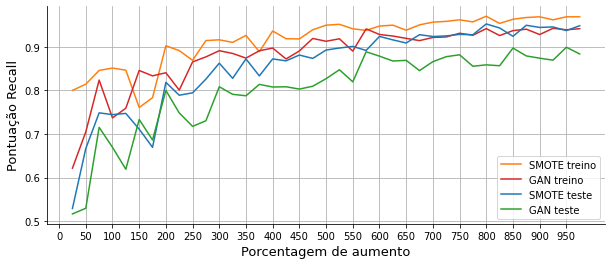

In [37]:
from bokeh.palettes import Category10_4
percentages = np.arange(25, 1000, 25)
plt.figure(figsize=(10,4));
ax = plt.subplot()
#plt.plot(percentages, smote_test_mean_score_p, label="SMOTE teste", color="#2477B0")
#plt.plot(percentages, smote_train_mean_score_p, label="SMOTE treino", color="#f9973c")
#plt.plot(percentages, gan_test_mean_score_p, label="GAN teste", ls="--", color="#2477B0")
#plt.plot(percentages, gan_train_mean_score_p, label="GAN treino", ls="--", color="#f9973c")
plt.plot(percentages, smote_train_mean_score_p, label="SMOTE treino", color=Category10_4[1])
plt.plot(percentages, gan_train_mean_score_p, label="GAN treino", ls="-", color=Category10_4[3])
plt.plot(percentages, smote_test_mean_score_p, label="SMOTE teste", color=Category10_4[0])
plt.plot(percentages, gan_test_mean_score_p, label="GAN teste", ls="-", color=Category10_4[2])
plt.grid()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlabel("Porcentagem de aumento", fontsize=13)
plt.ylabel("Pontuação Recall", fontsize=13)
plt.xticks(range(0,1000, 50), range(0,1000, 50))
plt.legend();


#### Conclusiones
- Se puede observar que la precisión del clasificador empleando el algoritmo SMOTE es un poco superior a la del clasificador empleando la arquitectura GAN. Esto podría deberse en parte a que el algoritmo SMOTE genera nuevo ejemplos muy semejantes en espacio a los reales, lo que ocasiona que el algoritmo tenga un espacio mas reducido para ajustar, llevando al clasificador a una precisión mas alta.

### comparando el recall score de los diferentes métodos

In [38]:
#x_ticks = [1.5,5.5]
smote_x_ticks = [2, 5]
gan_x_ticks = [2.5,5.5]
p = figure( width=350, height=210, background_fill_color="#efefef")

#----------------- SIN AUMENTAR ------------------

#------------------ SMOTE ------------------------
#lower and upper rects
p.rect(smote_x_ticks, [s_l_train, s_l_test], width=.12, height=.0004, line_color="black")
p.rect(smote_x_ticks, [s_u_train, s_u_test], width=.12, height=.0004, line_color="black")
#segments
p.segment(smote_x_ticks, [s_l_train, s_l_test], smote_x_ticks, [s_q25_train, s_q25_test], line_color="black")
p.segment(smote_x_ticks, [s_q75_train, s_q75_test], smote_x_ticks, [s_u_train, s_u_test], line_color="black")
#vars
p.vbar(smote_x_ticks, 0.35, [s_q50_train, s_q50_test], [s_q25_train, s_q25_test], line_color="black",
       fill_color="#F9A555")
p.vbar(smote_x_ticks, 0.35, [s_q50_train, s_q50_test], [s_q75_train, s_q75_test], line_color="black",
       fill_color="#F9A555", legend_label="SMOTE")
p.xaxis.axis_label = "conjunto de dados"
p.yaxis.axis_label = "pontuação recall"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"

#outliers
if len(s_otrain!=0):
    p.circle([smote_x_ticks[0]]*len(s_otrain), s_otrain, color="orange", line_width=1)
if len(otest!=0):
    p.circle([smote_x_ticks[1]]*len(s_otest), s_otest, color="orange", line_width=1)

#-----------------GAN----------------------
#lower and upper rects
p.rect(gan_x_ticks, [gan_l_train, gan_l_test], width=.12, height=.0005, line_color="black")
p.rect(gan_x_ticks, [gan_u_train, gan_u_test], width=.12, height=.0005, line_color="black")
#segments
p.segment(gan_x_ticks, [gan_l_train, gan_l_test], gan_x_ticks, [gan_q25_train, gan_q25_test], line_color="black")
p.segment(gan_x_ticks, [gan_q75_train, gan_q75_test], gan_x_ticks, [gan_u_train, gan_u_test], line_color="black")
#vars
p.vbar(gan_x_ticks, 0.35, [gan_q50_train, gan_q50_test], [gan_q25_train, gan_q25_test], line_color="black",
       fill_color="#4FA8E5", legend_label="GAN")
p.vbar(gan_x_ticks, 0.35, [gan_q50_train, gan_q50_test], [gan_q75_train, gan_q75_test], line_color="black",
       fill_color="#4FA8E5")
p.xaxis.axis_label = "Conjunto de dados aumentados"
p.yaxis.axis_label = "Pontuação Recall"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"

#outliers
if len(otrain!=0):
    p.circle([gan_x_ticks[0]]*len(gan_otrain), gan_otrain, color="orange", line_width=3)
if len(otest!=0):
    p.circle([gan_x_ticks[1]]*len(gan_otest), gan_otest, color="orange", line_width=3)

p.legend.label_text_font_size = '8pt'
p.legend.location = "bottom_center"
p.xaxis.ticker = [2.3, 5.3]
p.xaxis.major_label_overrides = { 2.3: 'Treino', 5.3: 'Teste'}


show(p)
p.output_backend = "svg"
export_svgs(p, filename="./results/recall_score_boxplot_comparation_GAN_vs_SMOTE.svg")

#### Siguiente paso:
- Una vez comparados visualmente, el proximo paso es comparar si estadísticamente el clasificador entrenado con los datos aumentados mediante el algoritmo SMOTE es diferente al clasificador entrenado con los datos aumentados mediante la arquitectura GAN.

In [39]:
len(smote_train_recall_score), len(smote_test_recall_score), len(gan_train_recall_score), len(gan_test_recall_score)

(50, 50, 50, 50)

#### Test de Shapiro-Wilk
- Primero hacemos el test de shapiro-wilk para saber si los datos provienen de una distribución normal.

In [40]:
from scipy.stats import shapiro, ttest_rel

print("train smote:", shapiro(smote_train_recall_score)[1])
print("test smote:", shapiro(smote_test_recall_score)[1])
print("train GAN:", shapiro(gan_train_recall_score)[1])
print("test GAN:", shapiro(gan_test_recall_score)[1])

train smote: 0.005783194210380316
test smote: 0.0064322794787585735
train GAN: 0.0031057093292474747
test GAN: 0.006129975896328688


- el test de shapiro para el algoritmo SMOTE muestra que la puntuación recall no sigue una distribución normal. Lo que significa que no se puede emplear un test paramétrico para medir si realmente son diferentes sus medias.

- lo que hacemos es emplear un test no paramétrico llamado Wilcoxon signed-rank test

In [41]:
from scipy.stats import wilcoxon

print("entrenamiento:", np.round(wilcoxon(smote_train_recall_score, gan_train_recall_score).pvalue,4))
print("test:", np.round(wilcoxon(smote_test_recall_score, gan_test_recall_score).pvalue, 4))

entrenamiento: 0.1487
test: 0.6122


In [42]:
print("----------- train -----------")
print("GAN:", np.round(np.mean(gan_train_recall_score), 4), np.round(np.std(gan_train_recall_score),4))
print("SMOTE:", np.round(np.mean(smote_train_recall_score),4), np.round(np.std(smote_train_recall_score),4))
print("----------- test -----------")
print("GAN:", np.round(np.mean(gan_test_recall_score), 4), np.round(np.std(gan_test_recall_score),4))
print("SMOTE:", np.round(np.mean(smote_test_recall_score),4), np.round(np.std(smote_test_recall_score),4))

----------- train -----------
GAN: 0.9704 0.0078
SMOTE: 0.9677 0.0087
----------- test -----------
GAN: 0.9335 0.0343
SMOTE: 0.939 0.0401


### Conclusiones
- El test muestra que para el conjunto de entrenamiento las puntuaciones recall son estadisticamente iguales, pero para el conjunto de test estas son estadisticamente diferentes.

- Obtamos por escoger la arquitectura GAN como método de aumento ya que está logra generar genes sintéticos basados en la distribución "aprendida" de los genes reales.